# Simple acoustic propagation

Before going on to simulate microbubbles, let's refresh some of the basics that we used to model acoustic wave propagation.

Using [Devito](https://www.devitoproject.org/), we provide an implementation of the second-order isotropic acoustic wave equation, which is governed by the equation,

$$
    \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} = \rho \nabla \cdot (\frac{1}{\rho} \nabla p) + \eta \frac{\partial}{\partial t} (-\nabla^2)^{y/2} p
$$

where $p(t, \mathbf{x})$ is the pressure, $v_p(\mathbf{x})$ is the longitudinal speed of sound, $\rho(\mathbf{x})$ is the mass density, $\eta = -2 \alpha_0 v_p^{y-1}$, and $\alpha_0(\mathbf{x})$ is the absorption coefficient.

Let's start our modelling exercise by importing some necessary libraries.

In [1]:
from stride import *
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

and, as usual, by creating our spatiotemporal grid,

In [2]:
space = Space(shape=(100, 100, 100),
              spacing=0.05e-3,
              extra=(30, 30, 30),
              absorbing=(20, 20, 20))

time = Time(start=0, step=0.005e-6, num=1500)

and our container `problem`.

In [3]:
# Create problem
problem = Problem(name='acoustic_propagation',
                  space=space, time=time)

Next, let's define the properties of the simulation region by creating `ScalarField` objects that specify a constant speed of sound and constant density.

In [4]:
# Create medium
vp = ScalarField(name='vp', grid=problem.grid)
vp.fill(1540.)

rho = ScalarField(name='rho', grid=problem.grid)
rho.fill(997)

problem.medium.add(vp)
problem.medium.add(rho)

We will use default point transducers for this exercise,

In [5]:
# Create transducers
problem.transducers.default()

arranged into an elliptical geometry with 120 locations.

In [6]:
# Create geometry
num_locations = 120
problem.geometry.default('elliptical', num_locations, radius=np.array(space.size)/2)

We create a single `shot`, in which we secify that the first geometry location will act as a source and all locations will act as receivers.

In [7]:
# Create acquisitions
shot = Shot(0,
            sources=[problem.geometry.locations[0]], 
            receivers=problem.geometry.locations,
            geometry=problem.geometry, problem=problem)

problem.acquisitions.add(shot)

By assigning a wavelet to our shot, we determine the excitation applied to our source: in this case a 6-cycle tone burst centred at 2 MHz.

In [8]:
from stride.utils import wavelets

# Create wavelets
f_centre = 2.00e6
n_cycles = 6
shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles,
                                               time.num, time.step) * 5e7

Finally, we can create our PDE object,

In [9]:
# Create the PDE
pde = IsoAcousticDevito(space=space, time=time)

Default Devito configuration:
	 * autotuning=['aggressive', 'runtime']
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp


and execute it by passing in relevant parameters.

In [10]:
sub_problem = problem.sub_problem(shot.id)
shot_wavelets = sub_problem.shot.wavelets

# Run
traces_0 = await pde(shot.wavelets, vp, rho=rho, problem=sub_problem, 
                     diff_source=True,
                     boundary_type='complex_frequency_shift_PML_2',
                     save_wavefield=True, save_undersampling=20)

(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 1.600-2.400 MHz
(ShotID 0) Spatial grid spacing (0.050 mm | 12.833 PPW) is below dispersion limit (0.128 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.005 μs | 15%) is below OT2 limit (0.012 μs)
(ShotID 0) Selected undersampling level 20
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 5e-05, h_y: 5e-05, h_z: 5e-05}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 18.27 s
  * lowering.Clusters: 11.60 s (63.6 %)
     * specializing.Clusters: 6.73 s (36.9 %)
        * fuse: 4.36 s (23.9 %)
  * lowering.Expressions: 4.14 s (22.7 %)
Flops reduction after symbolic optimization: [5668 --> 1306]
Operator `acoustic_iso_state` fetched `/tmp/devito-jitcache-uid1000/8802b177e029efa2677641734c93962a5be15130.c` in 0.66 s from jit-cache
(ShotID 0) Using inhomogeneous density
(ShotID 0) Running state equati

Let's plot the signal recorded by a single receiver, number 60, to check that the simulation worked as expected.

<IPython.core.display.Javascript object>


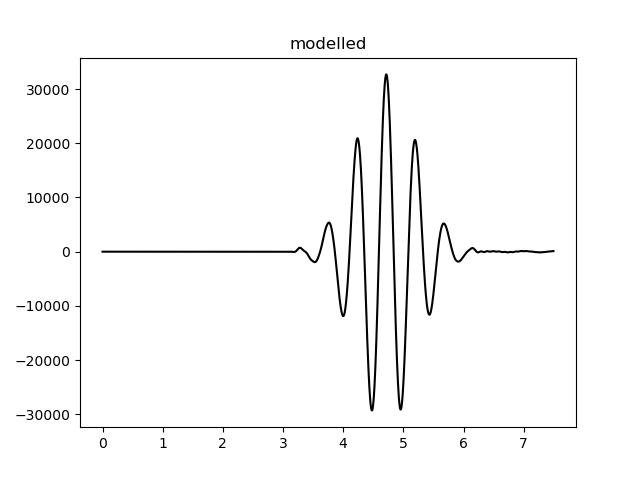

QApplication: invalid style override passed, ignoring it.
    Available styles: Windows, Fusion


<AxesSubplot:title={'center':'modelled'}>

In [11]:
traces_0.plot_one(60)

And, let's use a utility function to plot the generated wavefield propagating from right to left.

<IPython.core.display.Javascript object>


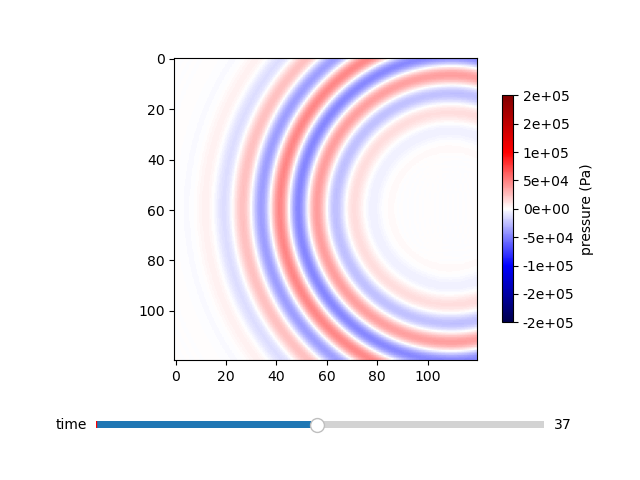

In [12]:
from utils import plot_wavefields

wavefield_0 = pde.wavefield.data[:, :, pde.wavefield.shape[-1]//2].copy()
plot_wavefields([wavefield_0], [dict(vmin=-200e3, vmax=200e3, cmap='seismic')])